### 01. 통계분석

##### Admission 데이터 변수의 설명은 아래와 같다.

<table>
    <thead>
        <tr>
            <th>변수</th>
            <th>데이터 형태</th>
            <th>설명</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>GRE</td>
            <td>수치형</td>
            <td>GRE점수</td>
        </tr>
        <tr>
            <td>TOEFL</td>
            <td>수치형</td>
            <td>TOEFL점수</td>
        </tr>
        <tr>
            <td>Univ_Rating</td>
            <td>수치형</td>
            <td>대학교 등급점수(1~5 사이의 숫자)</td>
        </tr>
        <tr>
            <td>SOP</td>
            <td>수치형</td>
            <td>자기소개서 점수</td>
        </tr>
        <tr>
            <td>LOR</td>
            <td>수치형</td>
            <td>추천서 점수</td>
        </tr>
        <tr>
            <td>CGPA</td>
            <td>수치형</td>
            <td>평점평균점수</td>
        </tr>
        <tr>
            <td>Research</td>
            <td>범주형</td>
            <td>연구 실적 유무(0: 없음, 1: 있음)</td>
        </tr>
        <tr>
            <td>Chance_of_Admit</td>
            <td>수치형</td>
            <td>입학 허가 확률</td>
        </tr>
    </tbody>
</table>

#### 1) 종속변수인 Chance_of_Admit(입학 허가 확률)와 독립변수(GRE, TOEFL, Univ_Rating, SOP, LOR, CGPA)에 대해 피어슨 상관계수를 이용한 상관관계 분석을 수행하고 그래프를 이용하여 분석결과를 설명하시오.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("data/모의고사 2회/Admission.csv", encoding="utf-8")
df

,GRE,TOEFL,Univ_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
395,324,110,3,3.5,3.5,9.04,1,0.82
396,325,107,3,3.0,3.5,9.11,1,0.84
397,330,116,4,5.0,4.5,9.45,1,0.91
398,312,103,3,3.5,4.0,8.78,0,0.67


In [2]:
#컬럼 값에 있는 공백 제거
new_cols = []
for col in df.columns:
    new_cols.append(col.strip())

df.columns = new_cols

In [3]:
#결측치 있는지 체크
for col in df.columns:
    isna = False
    isna_df = df[[col]].isna().query(col+" == True")
    if len(isna_df) > 0:
        isna = True
    print("{} : {} / len : {}".format(col, isna, len(isna_df)))

GRE : False / len : 0
TOEFL : False / len : 0
Univ_Rating : False / len : 0
SOP : False / len : 0
LOR : False / len : 0
CGPA : False / len : 0
Research : False / len : 0
Chance_of_Admit : False / len : 0


In [4]:
#상관계수 산출
var_list = []
for col in df.columns:
    if col != "Research":
        var_list.append(col)

df[var_list].corr()

,GRE,TOEFL,Univ_Rating,SOP,LOR,CGPA,Chance_of_Admit
GRE,1.000000,0.835977,0.668976,0.612831,0.557555,0.833060,0.802610
TOEFL,0.835977,1.000000,0.695590,0.657981,0.567721,0.828417,0.791594
Univ_Rating,0.668976,0.695590,1.000000,0.734523,0.660123,0.746479,0.711250
SOP,0.612831,0.657981,0.734523,1.000000,0.729593,0.718144,0.675732
LOR,0.557555,0.567721,0.660123,0.729593,1.000000,0.670211,0.669889
CGPA,0.833060,0.828417,0.746479,0.718144,0.670211,1.000000,0.873289
Chance_of_Admit,0.802610,0.791594,0.711250,0.675732,0.669889,0.873289,1.000000


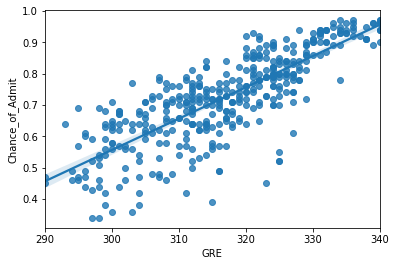

GRE - Chance_of_Admit
 └상관계수 : 0.8026104595903504, p-value : 2.4581124141786425e-91



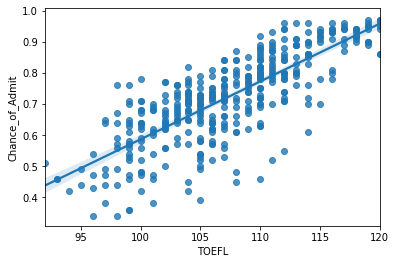

TOEFL - Chance_of_Admit
 └상관계수 : 0.7915939869351045, p-value : 3.6341021759970536e-87



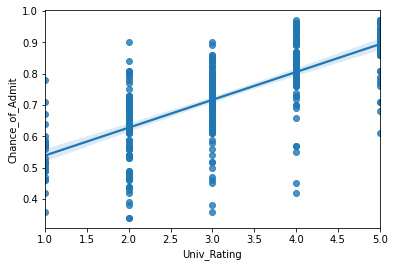

Univ_Rating - Chance_of_Admit
 └상관계수 : 0.7112502503917223, p-value : 6.635019480888325e-63



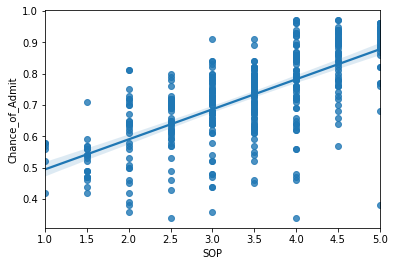

SOP - Chance_of_Admit
 └상관계수 : 0.6757318583886719, p-value : 1.1410946671023095e-54



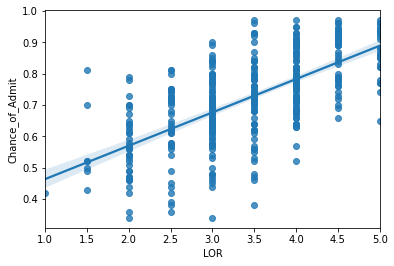

LOR - Chance_of_Admit
 └상관계수 : 0.669888792010694, p-value : 2.0073145197521393e-53



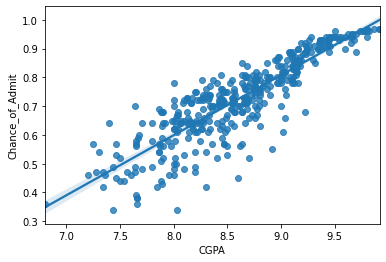

CGPA - Chance_of_Admit
 └상관계수 : 0.8732890993553002, p-value : 2.336514000497834e-126



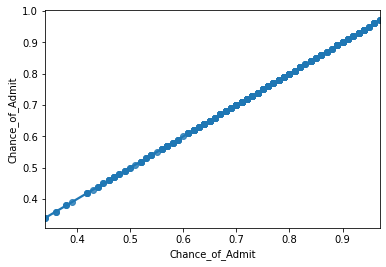

Chance_of_Admit - Chance_of_Admit
 └상관계수 : 1.0, p-value : 0.0

모두 양의 상관관계, 검정결과도 적합


In [5]:
import scipy.stats as stats

#scipy로 상관계수 계산 & 검정
for col in var_list:
    r = stats.pearsonr(df["Chance_of_Admit"], df[col])
    sns.regplot(x=df[col], y=df["Chance_of_Admit"])
    plt.show()
    print("{} - Chance_of_Admit".format(col))
    print(" └상관계수 : {}, p-value : {}".format(r[0], r[1]), end="\n\n")

print("모두 양의 상관관계, 검정결과도 적합")

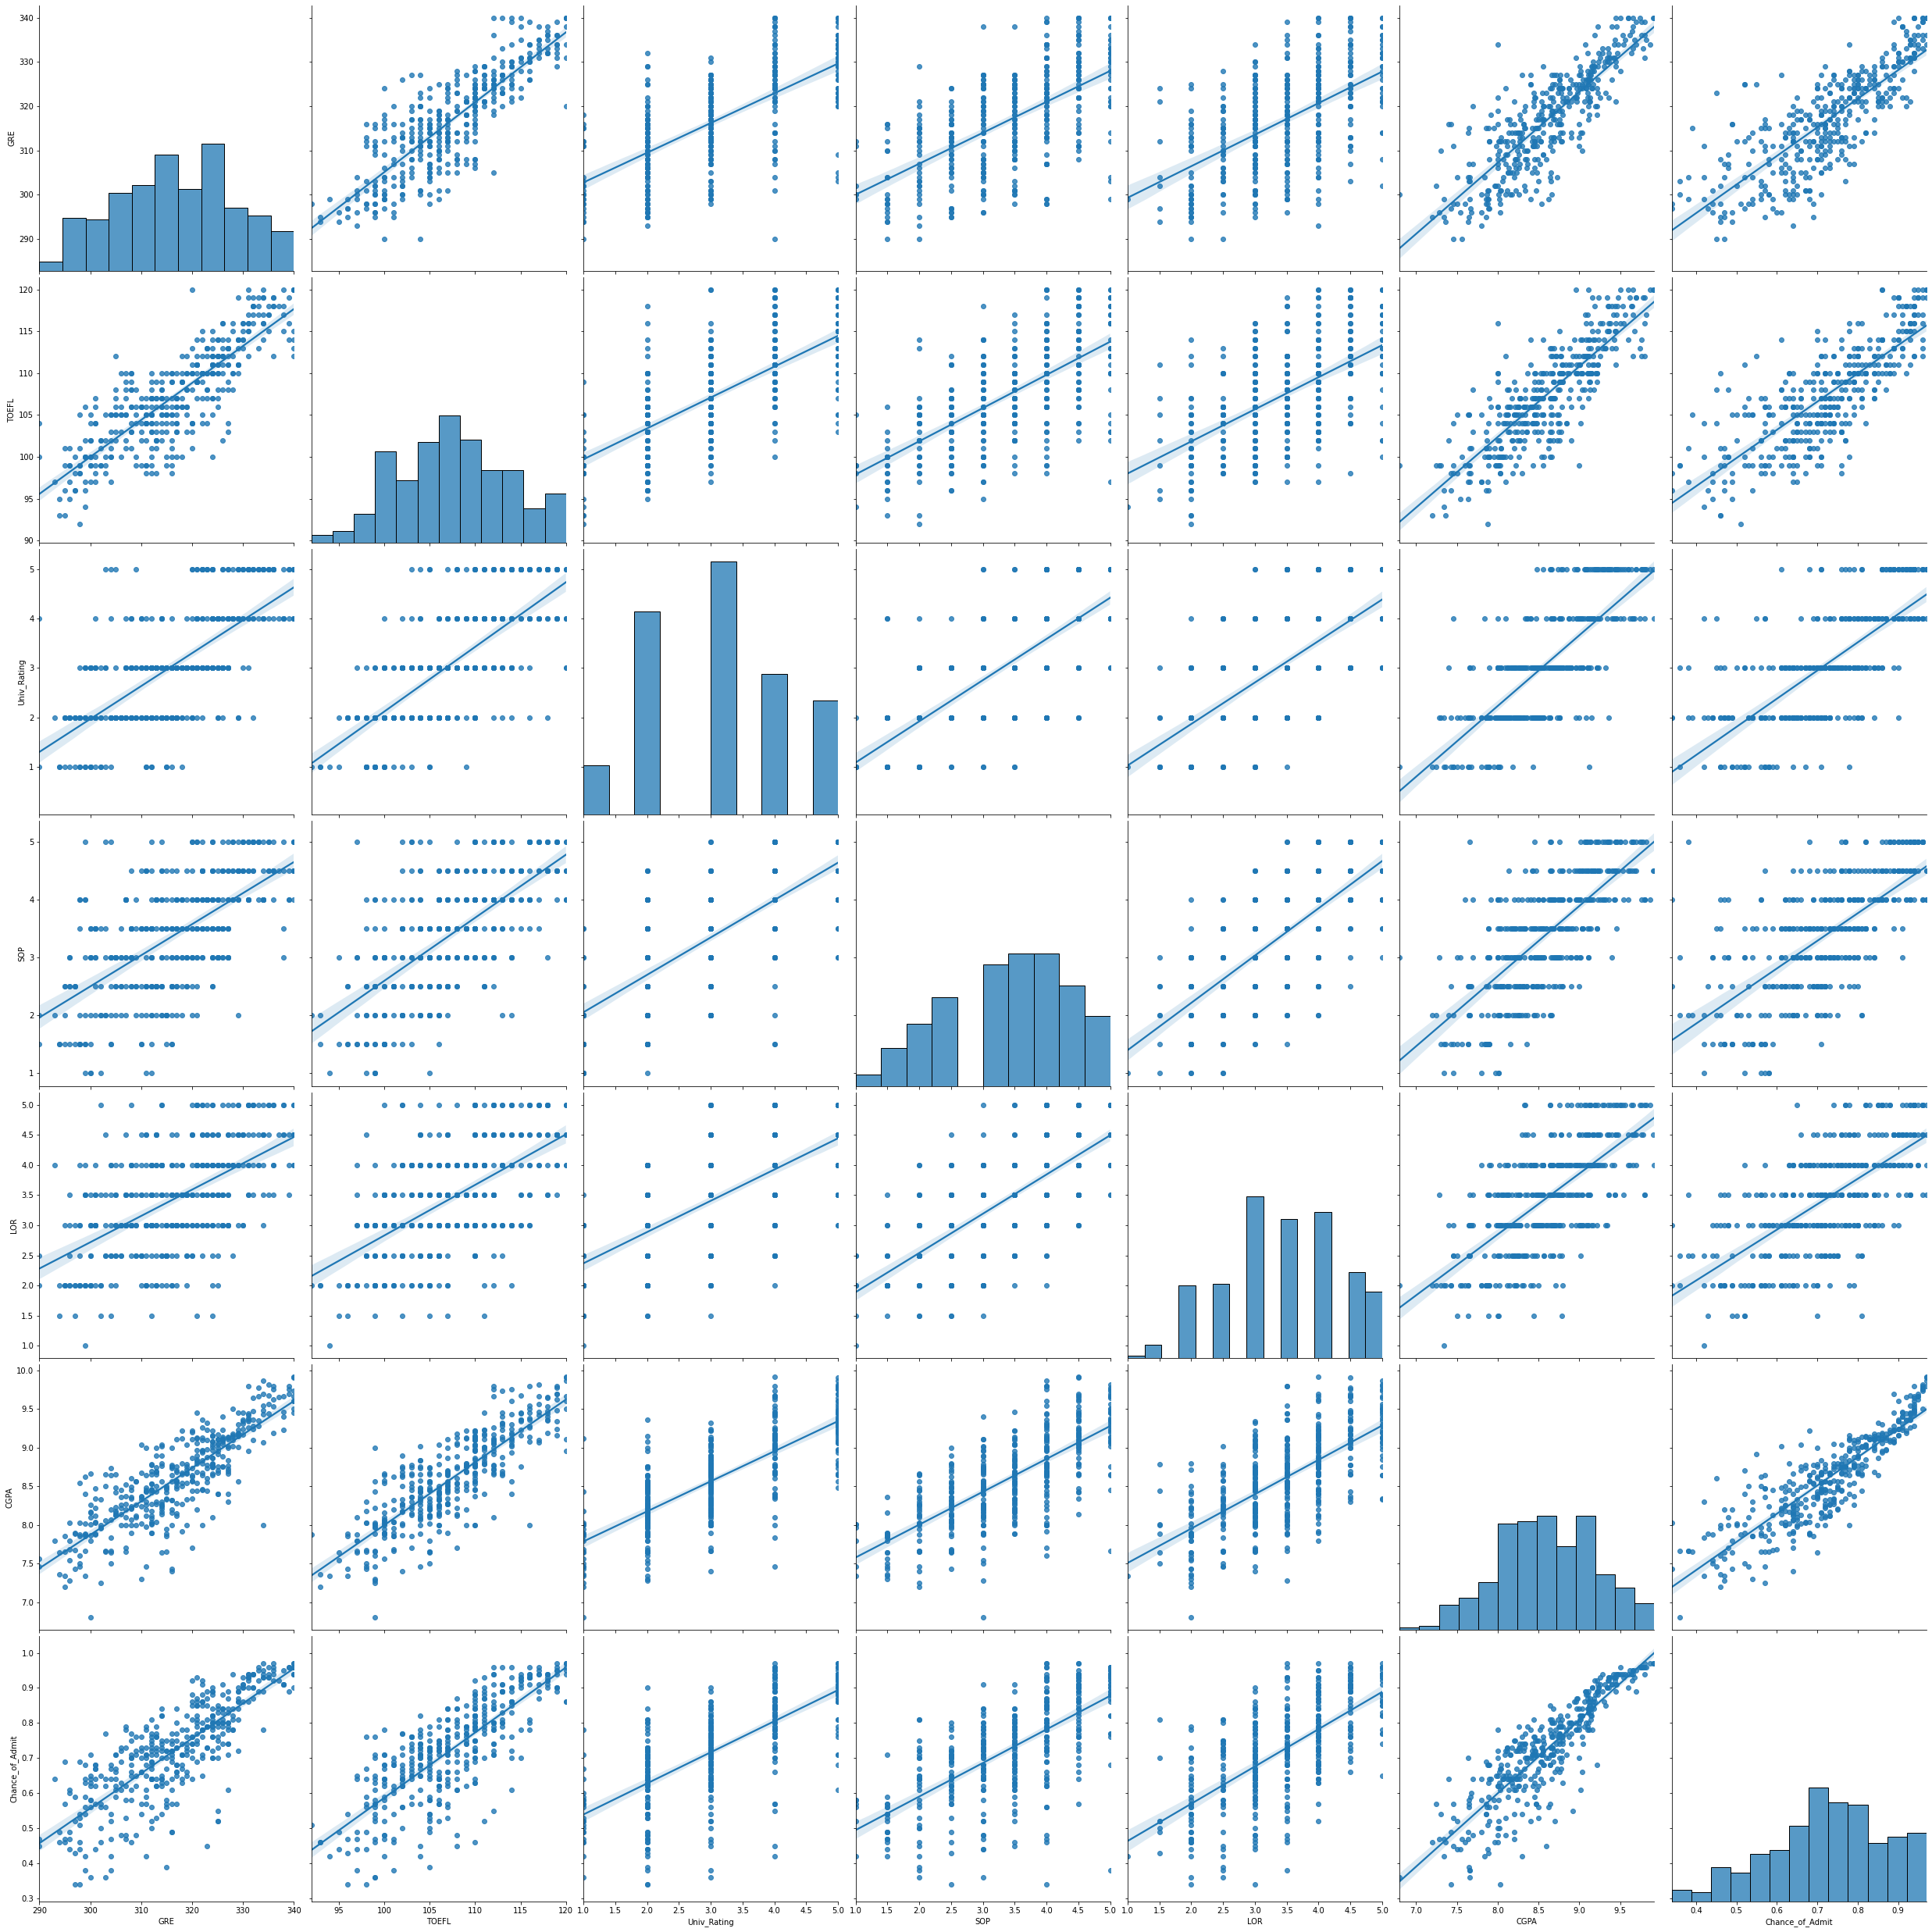

In [6]:
sns.pairplot(df[var_list], kind="reg", height=5)

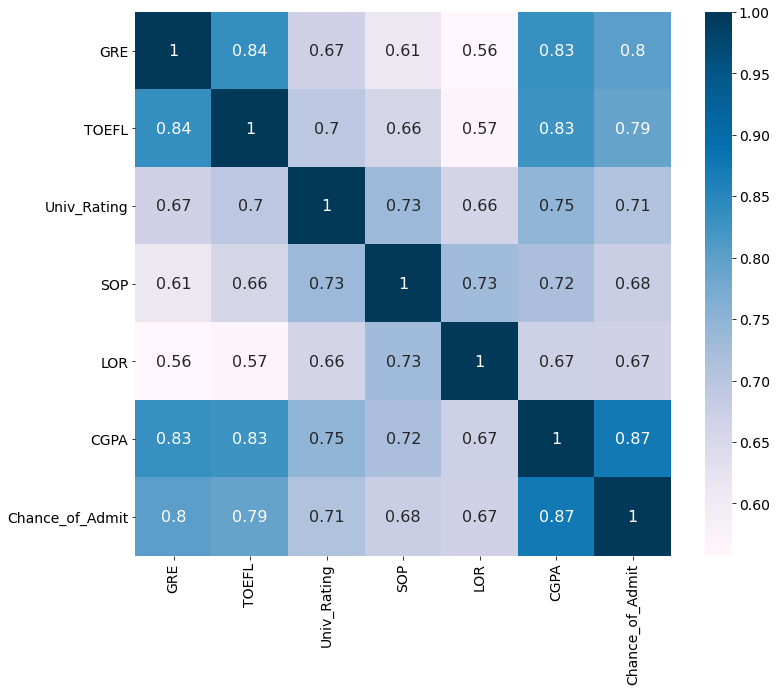

In [7]:
plt.figure(figsize=(12, 10))
plt.rcParams["font.size"] = 14
colormap = plt.cm.PuBu
sns.heatmap(df[var_list].corr(), cmap=colormap, annot = True, annot_kws = {"size" : 16})
plt.show()

#### 2) GRE, TOEFL, Univ_Rating, SOP, LOR, CGPA, Research가 Chance_of_Admit에 영향을 미치는지 알아보는 회귀분석을 단계적 선택법을 사용하여 수행하고 결과를 해석하시오.

참고 : https://no17.tistory.com/195 , https://mindscale.kr/course/basic-stat-python/13/

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn

model = None

In [9]:
def reg(df, dep_var, ind_vars):
    global model
    ind_vars_str = " + ".join(ind_vars)
    model = smf.ols(formula=dep_var+" ~ "+ind_vars_str, data=df)
    print(model.fit().summary())

In [10]:
dep_var = "Chance_of_Admit"
ind_vars = ["GRE", "TOEFL", "Univ_Rating", "SOP", "LOR", "CGPA", "Research"]

reg(df, dep_var, ind_vars)

                            OLS Regression Results                            
Dep. Variable:        Chance_of_Admit   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     228.9
Date:                Thu, 09 Sep 2021   Prob (F-statistic):          3.12e-134
Time:                        14:23:42   Log-Likelihood:                 537.37
No. Observations:                 400   AIC:                            -1059.
Df Residuals:                     392   BIC:                            -1027.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.2594      0.125    -10.097      

In [11]:
#다중공선성을 계산한다.
# print(model.exog_names) #독립변수 리스트 출력
factor1_vif = variance_inflation_factor(model.exog, 1) #첫번째 독립변수의 VIF를 계산해 준다.

vif_dic = []
for i, var in enumerate(model.exog_names):
    if i == 0:
        continue
    this_dic = {
        "독립변수" : model.exog_names[i],
        "VIF" : variance_inflation_factor(model.exog, i)
    }
    vif_dic.append(this_dic)
df_vif = pd.DataFrame(vif_dic)
display(df_vif)
print("CGPA의 VIF가 5 이상으로, 다중공선성 주의 필요")
#VIF가 10이 넘으면 다중공선성 있다고 판단하며 5가 넘으면 주의할 필요가 있는 것으로 봅니다.
#독립 변수 a와 b가 서로 상관 관계가 있다고 했을 때 두 변수 모두 VIF가 높습니다.
#어느 하나만 VIF가 높은 경우는 없습니다.
#박수도 오른손과 왼손이 있어야 칠 수 있듯이 서로 연관 있는 변수끼리 VIF가 높습니다.

,독립변수,VIF
0,GRE,4.615516
1,TOEFL,4.288959
2,Univ_Rating,2.919606
3,SOP,3.075504
4,LOR,2.431258
5,CGPA,5.207403
6,Research,1.543312


CGPA의 VIF가 5 이상으로, 다중공선성 주의 필요


In [12]:
#전진 선택법 함수를 만들어 보자 (단계적 선택법도 옵션에 포함)
#참고 : https://heejeongchoi.github.io/hydejack/2018-10-23-Supervised-Dimension-Reduction/
def forward_selection(df, dep_var, ind_vars, select_criteria = "AIC", stepwise=False):
    if stepwise:
        #후진제거법으로 제거되는 변수를 먼저 찾아 놓는다.
        eliminated_vars = backward_elimination(df, dep_var, ind_vars, "AIC", "e")
    candidate_vars = ind_vars.copy()
    selected_vars = [] #전진선택법으로 선택된 변수들
    alpha = 0.05 #새롭게 편입된 변수의 회귀계수 p-value가 0.05보다 작을 경우에만 선택
    
    while len(candidate_vars) > 0: #후보 변수 리스트가 모두 소거될 때까지 반복한다.
        candidate_vars_reg_result = []
        for candidate in candidate_vars:
            #새로운 변수가 추가되었을 때 회귀모형의 AIC와 r-square값을 구해본다.
            this_ind_vars_str = candidate
            if len(selected_vars) > 0:
                this_ind_vars_str = " + ".join(selected_vars) + " + " + candidate
            this_model_fit = smf.ols(dep_var+" ~ "+this_ind_vars_str, data=df).fit()
            this_result = {
                "var" : candidate,
                "AIC" : this_model_fit.aic,
                "rsquared_adj" : this_model_fit.rsquared_adj,
                "p-value" : this_model_fit.pvalues[candidate]
            }
            candidate_vars_reg_result.append(this_result)
        result = pd.DataFrame(candidate_vars_reg_result)
        ascending = True
        if select_criteria == "rsquared_adj":
            ascending = False
        result.sort_values(by=select_criteria, ascending=ascending, inplace=True)
        selected_var = result.iloc[0,[0]].values[0]
        selected_var_pvalue = result.iloc[0,[3]].values[0]
        if selected_var_pvalue > alpha:
            break
        selected_vars.append(selected_var)
        candidate_vars.remove(selected_var)
        if stepwise:
            #selected_vars 중에 eliminated_var에 해당하는 것이 있다면 제거한다
            if len(selected_vars) > 2 and len(eliminated_vars) > 0:
                for ev in eliminated_vars:
                    if ev in selected_vars:
                        selected_vars.remove(ev)
    print("후보 독립변수들 : {}".format(ind_vars))
    if stepwise:
        print("단계적 선택법 선택변수 : {}".format(selected_vars))
    else:
        print("전진선택법 선택변수 : {}".format(selected_vars))
    return selected_vars

forward_selected_ind_vars = forward_selection(df, dep_var, ind_vars, "AIC")

forward_selected_ind_vars_str = " + ".join(forward_selected_ind_vars)
model = smf.ols(dep_var+" ~ "+forward_selected_ind_vars_str, data=df)
model_fit = model.fit()
print(model_fit.summary())

후보 독립변수들 : ['GRE', 'TOEFL', 'Univ_Rating', 'SOP', 'LOR', 'CGPA', 'Research']
전진선택법 선택변수 : ['CGPA', 'GRE', 'LOR', 'Research', 'TOEFL']
                            OLS Regression Results                            
Dep. Variable:        Chance_of_Admit   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     320.6
Date:                Thu, 09 Sep 2021   Prob (F-statistic):          2.04e-136
Time:                        14:23:42   Log-Likelihood:                 536.61
No. Observations:                 400   AIC:                            -1061.
Df Residuals:                     394   BIC:                            -1037.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.97

In [13]:
#후진 제거법 함수를 만들어 보자
#참고 : https://heejeongchoi.github.io/hydejack/2018-10-23-Supervised-Dimension-Reduction/
def backward_elimination(df, dep_var, ind_vars, select_criteria = "AIC", return_case = "selected_vars"):
    alpha = 0.05
    selected_vars = ind_vars.copy()
    eliminated_vars = []
    done = False
    
    while done is False:
        #step1 : 변수 하나씩을 제외한 n개의 모델을 만들어낸다. (n : 변수 갯수)
        model_result_list = []
        for var in ind_vars:
            var_list = ind_vars.copy()
            if len(eliminated_vars)>0:
                var_list.remove(eliminated_vars)
            var_list.remove(var)
            this_ind_vars_str = " + ".join(var_list)
            this_model_fit = smf.ols(dep_var+" ~ "+this_ind_vars_str, data=df).fit()
            this_result = {
                "selected var" : this_ind_vars_str,
                "eliminated var" : var,            
                "AIC" : this_model_fit.aic,
                "rsquared_adj" : this_model_fit.rsquared_adj
            }
            model_result_list.append(this_result)
        result = pd.DataFrame(model_result_list)
        #step2 : n개 모델들 중 가장 좋은 결과를 보인 모델을 선택하고, 제외 후보 변수를 찾는다.
        ascending = True
        if select_criteria == "rsquared_adj":
            ascending = False
        result.sort_values(by=select_criteria, ascending=ascending, inplace=True)
        candidate_var = result.iloc[0, [1]].values[0]
        #step3 : 제외 후보 변수로 fitting하여 p-value를 알아보고 유의하다면 종료한다.
        candidate_model_fit = smf.ols(dep_var+" ~ "+candidate_var, data=df).fit()
        if candidate_model_fit.pvalues[candidate_var] > alpha: #유의하지 않다면
            eliminated_vars.append(candidate_var) #제거확정
            selected_vars.remove(candidate_var)
        else: #유의하다면 종료한다
            done = True
    if return_case == "s":
        print("후보 독립변수들 : {}".format(ind_vars))
        print("후진제거법 선택변수 : {}".format(selected_vars))
        return selected_vars
    elif return_case == "e":
        return eliminated_vars
    
backward_selected_ind_vars = backward_elimination(df, dep_var, ind_vars, "AIC", "s")

backward_selected_ind_vars_str = " + ".join(backward_selected_ind_vars)
model = smf.ols(dep_var+" ~ "+backward_selected_ind_vars_str, data=df)
model_fit = model.fit()
print(model_fit.summary())

후보 독립변수들 : ['GRE', 'TOEFL', 'Univ_Rating', 'SOP', 'LOR', 'CGPA', 'Research']
후진제거법 선택변수 : ['GRE', 'TOEFL', 'Univ_Rating', 'SOP', 'LOR', 'CGPA', 'Research']
                            OLS Regression Results                            
Dep. Variable:        Chance_of_Admit   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     228.9
Date:                Thu, 09 Sep 2021   Prob (F-statistic):          3.12e-134
Time:                        14:23:42   Log-Likelihood:                 537.37
No. Observations:                 400   AIC:                            -1059.
Df Residuals:                     392   BIC:                            -1027.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t

In [14]:
stepwise_selected_ind_vars = forward_selection(df, dep_var, ind_vars, "AIC", True)

stepwise_selected_ind_vars_str = " + ".join(stepwise_selected_ind_vars)
model = smf.ols(dep_var+" ~ "+stepwise_selected_ind_vars_str, data=df)
model_fit = model.fit()
print(model_fit.summary())

후보 독립변수들 : ['GRE', 'TOEFL', 'Univ_Rating', 'SOP', 'LOR', 'CGPA', 'Research']
단계적 선택법 선택변수 : ['CGPA', 'GRE', 'LOR', 'Research', 'TOEFL']
                            OLS Regression Results                            
Dep. Variable:        Chance_of_Admit   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     320.6
Date:                Thu, 09 Sep 2021   Prob (F-statistic):          2.04e-136
Time:                        14:23:42   Log-Likelihood:                 536.61
No. Observations:                 400   AIC:                            -1061.
Df Residuals:                     394   BIC:                            -1037.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.

#### 3) 단계 선택법을 사용해 변수를 선택한 후 새롭게 생성한 회귀모형에 대한 잔차분석을 수행하고, 그래프를 활용하여 결과를 해석하시오.

잔차의 3가지 가정 : 독립성, 정규성, 등분산성

##### 잔차의 독립성 검증

Durbin-watson 검정으로 체크. 잔차의 독립성이 확보되어야 회귀모형의 검증력이 인정을 받음

※잔차의 독립성 : 잔차들끼리 상관관계가 없다는 것을 의미. 즉, 자기상관이 없다는 것. 자기상관이 있다면 F값과 t값, r스퀘어 값이 과장되어 나타날 수 있음

※더빈왓슨 수치의 해석 : 0 ~ 4 사이의 값을 가지며 2와 가까울수록 독립성이 있다고 봄. 0이나 4에 가까운 숫자라면 독립성이 없다고 봄



In [15]:
#summary()의 더빈왓슨 결과값은 0.750으로 0에 가까우므로 독립성 있다 보기 어려움

##### 잔차의 정규성 검증

샤피로 윌크 검정으로 체크. p-value가 0.05보다 작다면 귀무가설(=정규성이 있다)을 기각

In [16]:
from scipy import stats

predict = model_fit.predict(df)
predict.name="predict"

residual = df[dep_var] - predict
residual.name="residual"

stats.shapiro(residual)

#p-value가 1.44e-13으로 아주 낮게 나와 정규성이 없다고 판단

ShapiroResult(statistic=0.9219251275062561, pvalue=1.4429574885215651e-13)

Q-Q plot으로 시각화하여 정규성 체크

X축은 정규분포곡선의 확률분포 위치값, Y축은 잔차가 정규분포곡선의 분포와 비교해 얼마나 떨어져 있는지의 값

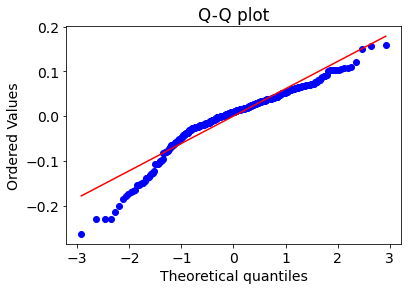

In [17]:
from scipy import stats

stats.probplot(residual, plot=plt)
plt.title("Q-Q plot")
plt.show()

#붉은선에서 벗어나 있으면(대각선이 아니면) 정규성 없다고 봄

#### 그래프를 통해 등분산성 체크

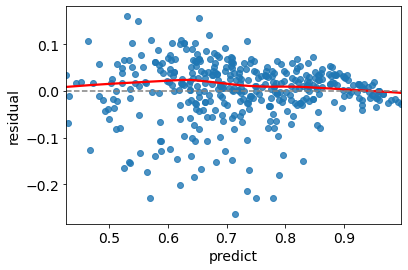

In [18]:
# df_residual = pd.concat([df[dep_var], predict, residual], axis=1)
# display(df_residual)

#붉은색 선이 직선에 가까우면 등분산으로 볼 수 있음
sns.regplot(x=predict, y=residual, lowess=True, line_kws={'color': 'red'})
plt.plot([predict.min(), predict.max()], [0, 0], '--', color='grey')